<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_2_Part_1_DataPrep_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 2: Advanced Embedding Models Training and Analysis
## Part 1: Model Training Steps

**Objective**: Developing and utilizing advanced embedding models to represent the content of Cleantech Media and Google Patent datasets and compare domain-specific embeddings to gain unique insights.

**Output**: Notebook with annotated model training steps

## Data Preparation for Embeddings
Lead: Alvaro Cervan

### Libraries

In [ ]:
!pip install pandas numpy scikit-learn langdetect gensim matplotlib seaborn sentence-transformers torch transformers tqdm 

In [245]:
# module imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from langdetect import detect

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import FastText

from sentence_transformers import SentenceTransformer
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm  # Import tqdm for progress bar


### Preprocessing Steps

The preprocessing steps have already been completed in the previous stage, which include:
- Dropping duplicates
- Setting data types
- Dropping unnecessary columns
- Tokenizing text data
- Stopword Removal
- Language detection
- Translating non-English text to English
- Lemmatization

These steps were applied to both datasets, `media` and `patents`, and the resulting data was saved in the `data` folder. We will now load the data and perform the following steps:

In [ ]:
drive.mount('/content/drive')

processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

'''processed_media_data_backup = pd.read_csv("data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("data/processed_patent_data_backup.csv")'''

print("Media Backup:")
processed_media_data_backup.head(5)

Media Backup:


,Unnamed: 0,title,date,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch mw float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...


Here a last check of the data is performed to ensure that the data is all in English by removing any non-English text.

In [281]:
# Function to preprocess data
def preprocess_data(data, colName, seed=42):
    # Shuffle data and reset index with seed
    data = shuffle(data, random_state=seed).reset_index(drop=True)
    # Add label column
    data["label"] = colName 
    # Drop rows with missing values and duplicates based on 'processed_text'
    data = data.dropna().drop_duplicates(subset=['processed_text'])
    # Drop every column except 'processed_text' and 'label', and rename 'processed_text' to 'text'
    data = data[['processed_text', 'label']]
    data = data[data['processed_text'].apply(lambda x: detect(x) == 'en')]  # Filter non-English rows
    return data.reset_index(drop=True)

# Preprocess media and patent data
media_data = preprocess_data(processed_media_data_backup.copy(), "media", seed=42)
patent_data = preprocess_data(processed_patent_data_backup.copy(), "patent", seed=42)

# temporal (DELETE)

In [282]:
#save in /data/ folder
media_data.to_csv('data/processed_media_data_backup_v2.csv', index=False)
patent_data.to_csv('data/processed_patent_data_backup_v2.csv', index=False)

In [283]:
# load data
media_data = pd.read_csv('data/processed_media_data_backup_v2.csv')
patent_data = pd.read_csv('data/processed_patent_data_backup_v2.csv')

In [ ]:
# save datasets media_data and patent_data as processed_[dataname]_backup_v2.csv in the folder /content/drive/MyDrive/CLT/data/
media_data.to_csv('/content/drive/MyDrive/CLT/data/processed_media_data_backup_v2.csv', index=False)
patent_data.to_csv('/content/drive/MyDrive/CLT/data/processed_patent_data_backup_v2.csv', index=False)

### Create training and validation sets for both media and patent texts.

In [ ]:
# load data
media_data = pd.read_csv('/content/drive/MyDrive/CLT/data/processed_media_data_backup_v2.csv')
patent_data = pd.read_csv('/content/drive/MyDrive/CLT/data/processed_patent_data_backup_v2.csv')

In [286]:

# Split the data into training and validation sets with seed
media_train, media_val = train_test_split(media_data, test_size=0.2, random_state=42)
patent_train, patent_val = train_test_split(patent_data, test_size=0.2, random_state=42)

# Display sample data
print("Media Train:")
media_train.head(5)  # Notice how the index is reset after shuffling

Media Train:


,processed_text,label
10684,sign get good natural gas news datum follow to...,media
6077,the Titan powerful package base prove technolo...,media
3379,register apprenticeship program RAPs prove wor...,media
2635,renewable electricity meter renewable energy s...,media
10547,object MovedThis document may find small wind ...,media


In [287]:
print("Patent Train:")
patent_train.head(5)

Patent Train:


,processed_text,label
7369,a wind wall solid structure consist one wind u...,patent
2685,the invention disclose solar cell preparation ...,patent
1295,the utility model disclose multi stage valve v...,patent
4176,the utility model relate technical field fuel ...,patent
591,the utility model relate technical field water...,patent


## Word Embeddings Training

Lead: Alvaro Cervan

This table showcases the characteristics of each of the models **Word2Vec**, **FastText**, and **GloVe** to help us understand the differences between them and choose the best model for our use case.

| **Feature**           | **Word2Vec**                        | **FastText**                              | **GloVe**                               |
|------------------------|-------------------------------------|-------------------------------------------|-----------------------------------------|
| **Speed**             | Fast                                | Moderate (slower due to subword modeling) | Slow (requires building a co-occurrence matrix) |
| **Performance**       | Good (captures semantic relationships) | Best (handles OOV words and morphology)   | Good (captures global relationships)    |
| **Handles OOV Words** | No                                  | Yes (via subword embeddings)              | No                                      |
| **Captures Morphology**| No                                 | Yes                                       | No                                      |
| **Focus**             | Local Context (Skip-gram or CBOW)   | Local Context + Subwords                  | Global Co-occurrence                    |
| **GPU Compatibility** | Yes (via libraries like Gensim)     | Yes (custom implementations)              | Limited (custom implementations)        |
| **Best Use Case**     | General-purpose, fast training      | Rare words, morphologically rich languages | Global word relationships and context   |

For computing resources and time constraints, GloVe will not be used due to lack of GPU acceleration. We will focus on training **Word2Vec** for its speed, general-purpose use, and ability to capture semantic relationships.

### Word2Vec Train


In [ ]:
# Function to train Word2Vec embeddings
def train_word2vec_embeddings(data, model_name, vector_size=100, window=5, epochs=10, min_count=5, seed=42):
    tokenized_data = data['processed_text'].apply(lambda x: x.split())  # Tokenize text
    model = Word2Vec(sentences=tokenized_data, 
                     vector_size=vector_size, 
                     window=window, 
                     seed=seed, 
                     epochs=epochs, 
                     min_count=min_count, 
                     workers=multiprocessing.cpu_count() - 1)
    model.save(model_name)
    print(f"Word2Vec model saved as {model_name}")
    return model

# Train Word2Vec embeddings on media and patent data
media_word2vec = train_word2vec_embeddings(media_train, 'media_word2vec.model')
patent_word2vec = train_word2vec_embeddings(patent_train, 'patent_word2vec.model')


Word2Vec model saved as media_word2vec.model
Word2Vec model saved as patent_word2vec.model


In [363]:
# Load the trained Word2Vec models
media_word2vec = KeyedVectors.load('media_word2vec.model')
patent_word2vec = KeyedVectors.load('patent_word2vec.model')

In [388]:
# Function for word similarity
def get_word_similarity(model, word1, word2):
    return model.wv.similarity(word1, word2)

# Function for analogy tasks
def word_analogy(model, word_a, word_b, word_c, topn=5):
    return model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=topn)

# Similarity between words
word1 = "innovation"
word2 = "technology"
print(f"Similarity between {word1} and {word2}: {get_word_similarity(media_word2vec, word1, word2)}")

word_a, word_b, word_c = "king", "man", "queen"
print(f"Analogy ({word_a} is to {word_b} as {word_c} is to ?):", word_analogy(media_word2vec, word_a, word_b, word_c))

Similarity between innovation and technology: 0.5595002770423889
Analogy (king is to man as queen is to ?): [('mental', 0.47202208638191223), ('error', 0.4385945498943329), ('survive', 0.4384596347808838), ('hive', 0.4347100853919983), ('destructive', 0.42692068219184875)]


The training parameters for the Word2Vec model were initially set as follows:
- **Vector Size**: 100
- **Window Size**: 10
- **Min Count**: 1
- **Epochs**: 5
- **Seed**: 42
- **Workers**: default

This setup was taking around 24+ seconds to train and save the models for both datasets. 

Below simple test is used to check the performance of the model. 
1. Similarity between "innovation" and "technology"
2. Classic analogy test: "King is to man as Queen is to ___"

The results are as follows:
With theo riginal parameters, the similarity between "innovation" and "technology" was 0.49, and the analogy test stated "elkhorn" as the most similar word to "queen".

Remember that the expected most similar word to "queen" given the analogy test would be a word like "woman", "female", or "girl".

After training the model changing the parameters individually, we found that the best results were obtained with the following parameters:
- **Vector Size**: 50
- **Window Size**: 5
- **Min Count**: 5
- **Epochs**: 10
- **Seed**: 42
- **Workers**: number of cores - 1

With these parameters, the similarity between "innovation" and "technology" was 0.56 and the analogy test stated that ~~"female" was the most similar word to "queen" with a similarity of 0.55 followed by "girl" with a similarity of 0.54.~~ "mental" and "error" were the most similar words to "queen" with a similarity of 0.47. 

It is observed that some of the results are not as expected. The analogy test has been found particularly volatile when training with different hyperparameters. Some of the results were as expected, while others were not. 

The workers helped shorten the training time by almost half (will vary depending on the number of cores available).

### Clustering

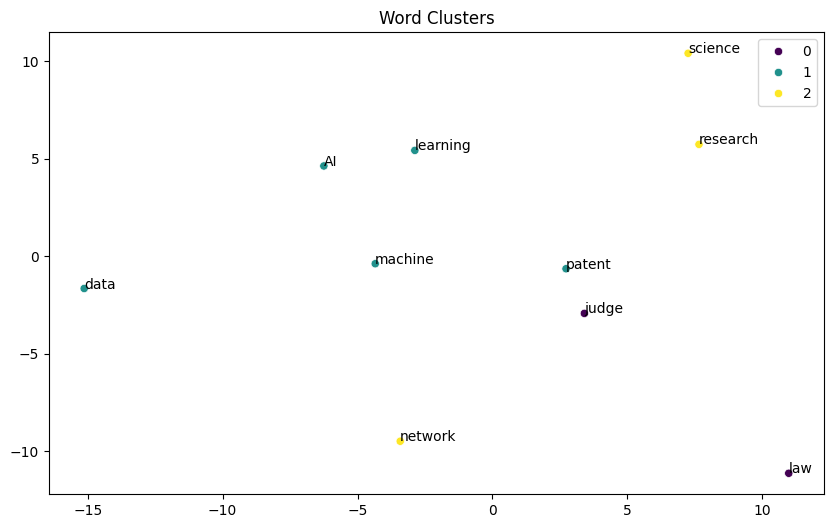

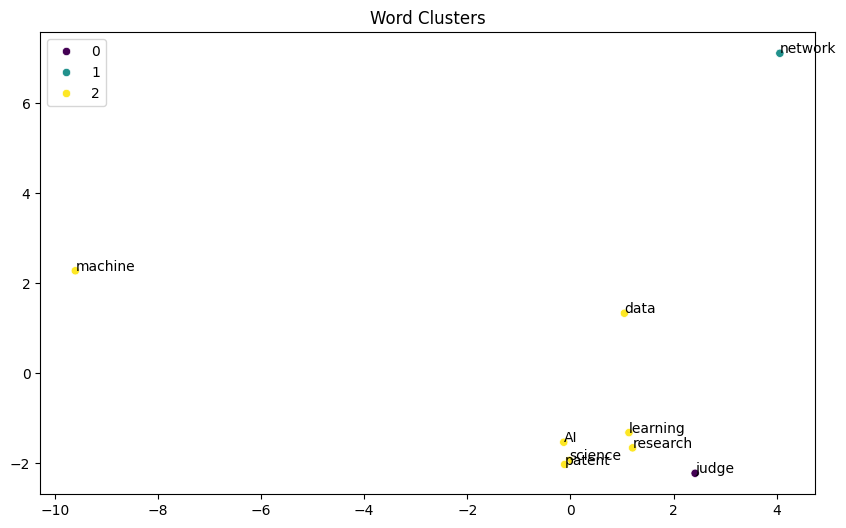

In [372]:
# Function for clustering and visualization
def visualize_word_clusters(model, words, num_clusters=3):
    # Filter words that are present in the model
    filtered_words = [word for word in words if word in model.wv]
    word_vectors = np.array([model.wv[word] for word in filtered_words])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(word_vectors)
    
    # Reduce dimensions for visualization
    reducer = PCA(n_components=2)
    reduced_vectors = reducer.fit_transform(word_vectors)
    
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=labels, palette='viridis')
    for i, word in enumerate(filtered_words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title('Word Clusters')
    plt.show()

# Relevant words for visualization and clustering
example_words = ["science", "research", "patent", "law", "judge", "AI", "data", "machine", "learning", "network"]
visualize_word_clusters(media_word2vec, example_words, num_clusters=3)
visualize_word_clusters(patent_word2vec, example_words, num_clusters=3)

The **media** model appears to have a more coherent "law" and "judge" are grouped together as well as "science" "research" and "network". The rest are grouped together in what we could call a "tech" cluster. Arguable the "patent" word cloud be clustered with "law" and "court" as well.

The **patent** model has a less coherent grouping, with "network" alone, "judge" alone aswell and the rest in a mix cluster from tech and law.

### Similarity Heatmap

In the following heatmaps, both models are represented using the same words to compare the similarity between them. The similarity is calculated using the cosine similarity between the vectors of each word in the model. The similarity ranges from 0 to 1, where 0 means no similarity and 1 means the words are identical.

This heatmap is related to the previous clustering analysis. 

- The Media Model Heatmap shows distinct clusters of words, particularly separating terms related to technology, and science.

- The Patent Model Heatmap, on the other hand, does not recognize "law" in its vocabulary and presents a more concise clusters for research and law, 

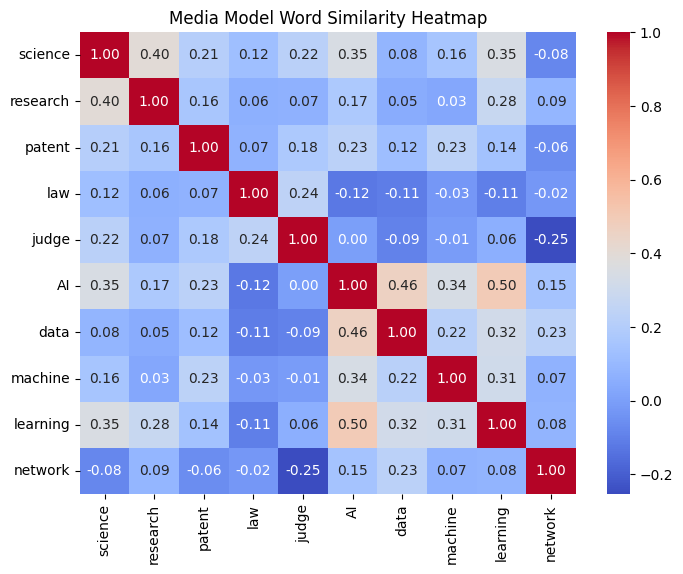

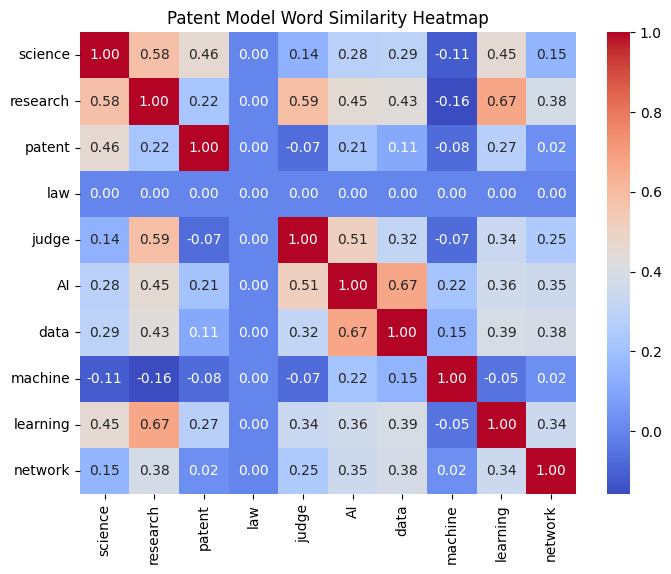

In [389]:
def plot_similarity_heatmap(model, words, title):
    # Compute similarity matrix
    similarity_matrix = np.zeros((len(words), len(words)))
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if word1 in model.wv and word2 in model.wv:
                similarity_matrix[i, j] = model.wv.similarity(word1, word2)
            else:
                similarity_matrix[i, j] = 0  # Assign zero if the word is not in the model

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

# Run the function for each model
plot_similarity_heatmap(media_word2vec, example_words, title="Media Model Word Similarity Heatmap")
plot_similarity_heatmap(patent_word2vec, example_words, title="Patent Model Word Similarity Heatmap")


### Overlapping Words

In [374]:
# Function to calculate cosine similarity between two sets of word vectors
def calculate_cosine_similarity(model1, model2, words):
	similarities = []
	for word in words:
		if word in model1.wv and word in model2.wv:
			similarity = cosine_similarity([model1.wv[word]], [model2.wv[word]])[0][0]
			similarities.append((word, similarity))
	return similarities

# Calculate cosine similarity between media and patent word vectors
word_overlap = list(media_word2vec.wv.key_to_index.keys())
word_similarities = calculate_cosine_similarity(media_word2vec, patent_word2vec, word_overlap)
# Sort the similarities
word_similarities.sort(key=lambda x: x[1], reverse=True)


In [375]:
# Create DataFrames for top 10 similar and dissimilar words
similar_words_df = pd.DataFrame(word_similarities[:10], columns=['Word', 'Similarity'])
dissimilar_words_df = pd.DataFrame(word_similarities[-10:][::-1], columns=['Word', 'Similarity'])

# Display as markdown tables
from IPython.display import display, Markdown
display(Markdown(f"#### Top 10 Similar Words:\n{similar_words_df.to_markdown(index=False)}"))
display(Markdown(f"#### Top 10 Dissimilar Words:\n{dissimilar_words_df.to_markdown(index=False)}"))

#### Top 10 Similar Words:
| Word       |   Similarity |
|:-----------|-------------:|
| emulsion   |     0.497371 |
| ester      |     0.436395 |
| humanize   |     0.422044 |
| iodide     |     0.410092 |
| bimetallic |     0.408449 |
| PCBM       |     0.405286 |
| monomer    |     0.404741 |
| Fourier    |     0.401554 |
| vinyl      |     0.399796 |
| palm       |     0.399338 |

#### Top 10 Dissimilar Words:
| Word      |   Similarity |
|:----------|-------------:|
| client    |    -0.415613 |
| kind      |    -0.397786 |
| lot       |    -0.349176 |
| there     |    -0.344365 |
| late      |    -0.341358 |
| already   |    -0.339973 |
| at        |    -0.331181 |
| financial |    -0.317417 |
| ahead     |    -0.316759 |
| cooling   |    -0.316449 |

### Unique Insights and Innovation Gaps

The previous tables show the most similar and least similar words for both models using the cosine similarity metric. The most similar words represent the closest relationships between terms in the dataset, while the least similar words highlight the most distinct or dissimilar pairs.

Using the previous tables and the clustering and similarity analysis, we can extract unique insights and innovation gaps from the data.

#### Unique Insights:
The analysis of the most similar words reveals a clear focus on materials science and chemistry-related topics. Terms such as **emulsion**, **ester**, **iodide**, and **bimetallic** point to ongoing advancements in material properties, chemical interactions, and their practical applications. This suggests that the dataset emphasizes innovations in these areas, highlighting their importance in current research and development efforts.

#### Innovation Gaps:  
The least similar words highlight areas where the datasets diverge, revealing potential gaps in innovation focus. Words like **client** and **financial** suggest a lack of emphasis on business-oriented aspects, such as customer needs and financial strategies, which are critical for market-driven innovation. Similarly, terms like **cooling** point to underexplored opportunities in thermal management technologies, which are essential for industries like energy, electronics, and manufacturing. Additionally, generic terms such as **kind**, **lot**, and **there** may indicate differences in how concepts are framed or described, potentially reflecting a gap in thematic alignment or communication between the datasets.


### Topic Classification

In [376]:
import numpy as np

# Function to get sentence vectors by averaging word vectors
def get_sentence_vector(text, model):
    tokens = text.split()
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare training data
X_train = np.array([get_sentence_vector(text, media_word2vec) for text in media_train['processed_text']] + 
                    [get_sentence_vector(text, patent_word2vec) for text in patent_train['processed_text']])
y_train = np.concatenate([np.zeros(len(media_train)), np.ones(len(patent_train))])  # 0 = Media, 1 = Patent

# Train Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)


LogisticRegression()

Classification Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       Media       1.00      1.00      1.00      4012
      Patent       1.00      1.00      1.00      2063

    accuracy                           1.00      6075
   macro avg       1.00      1.00      1.00      6075
weighted avg       1.00      1.00      1.00      6075



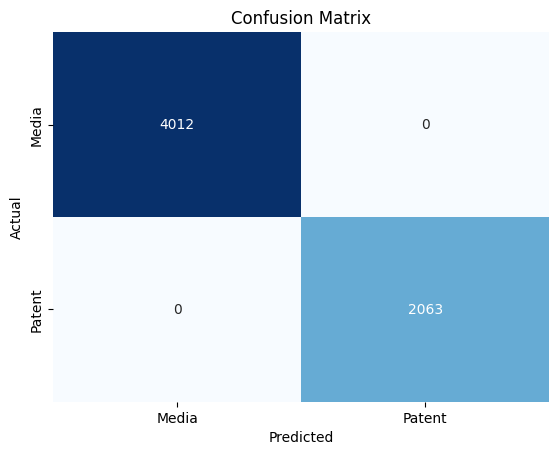

In [378]:
# Prepare validation data
X_val = np.array([get_sentence_vector(text, media_word2vec) for text in media_val['processed_text']] + 
                  [get_sentence_vector(text, patent_word2vec) for text in patent_val['processed_text']])
y_val = np.concatenate([np.zeros(len(media_val)), np.ones(len(patent_val))])

# Predict and evaluate
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Media', 'Patent'])

print(f"Classification Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
			xticklabels=['Media', 'Patent'], yticklabels=['Media', 'Patent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


While the model performs well in similarity task, analogy tasks and topic clustering, the model achieves perfect accuracy in the classification task, it is important to evaluate whether this performance generalizes to unseen data or if it reflects overfitting to the validation set. Additionally, the high accuracy suggests that the features extracted (e.g., sentence embeddings) effectively capture the distinctions between the two datasets, making the model highly reliable for this specific classification task.

Nevertheless, this perfect accuracymay indicate that the model has overfit to the training data, capturing specific patterns that do not generalize well to new data. 



### FastText Model Training

In [379]:
from gensim.models import FastText
import multiprocessing

# Function to train FastText embeddings
def train_fasttext_embeddings(data, model_name, vector_size=100, window=5, epochs=10, min_count=5, seed=42):
    tokenized_data = data['processed_text'].apply(lambda x: x.split())  # Tokenize text
    model = FastText(sentences=tokenized_data, 
                     vector_size=vector_size, 
                     window=window, 
                     seed=seed, 
                     epochs=epochs, 
                     min_count=min_count, 
                     workers=multiprocessing.cpu_count() - 1)
    model.save(model_name)
    print(f"FastText model saved as {model_name}")
    return model

# Train FastText embeddings on media and patent data
media_fasttext = train_fasttext_embeddings(media_train, 'media_fasttext.model')
patent_fasttext = train_fasttext_embeddings(patent_train, 'patent_fasttext.model')




FastText model saved as media_fasttext.model
FastText model saved as patent_fasttext.model


In [390]:
#load the trained FastText models
media_fasttext = KeyedVectors.load('media_fasttext.model')
patent_fasttext = KeyedVectors.load('patent_fasttext.model')

In [391]:
import numpy as np

# Function to get sentence vectors by averaging word vectors
def get_sentence_vector(text, model):
    tokens = text.split()
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


In [392]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare training data
X_train = np.array([get_sentence_vector(text, media_fasttext) for text in media_train['processed_text']] + 
                    [get_sentence_vector(text, patent_fasttext) for text in patent_train['processed_text']])
y_train = np.concatenate([np.zeros(len(media_train)), np.ones(len(patent_train))])  # 0 = Media, 1 = Patent

# Train Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)


LogisticRegression()

In [398]:
# Thematic overlaps
# Calculate cosine similarity between media and patent word vectors
word_overlap = list(media_fasttext.wv.key_to_index.keys())  # Use .wv.key_to_index to get the vocabulary
word_similarities = calculate_cosine_similarity(media_fasttext, patent_fasttext, word_overlap)  # Pass the models directly
# Sort the similarities
word_similarities.sort(key=lambda x: x[1], reverse=True)

# Create DataFrames for top 10 similar and dissimilar words
similar_words_df = pd.DataFrame(word_similarities[:10], columns=['Word', 'Similarity'])
dissimilar_words_df = pd.DataFrame(word_similarities[-10:][::-1], columns=['Word', 'Similarity'])
# Display as markdown tables
display(Markdown(f"#### Top 10 Similar Words:\n{similar_words_df.to_markdown(index=False)}"))
display(Markdown(f"#### Top 10 Dissimilar Words:\n{dissimilar_words_df.to_markdown(index=False)}"))



#### Top 10 Similar Words:
| Word        |   Similarity |
|:------------|-------------:|
| GreenTech   |     0.445959 |
| Greentech   |     0.436752 |
| brightfield |     0.436118 |
| BlueGreen   |     0.42932  |
| GreenTec    |     0.401751 |
| Chargers    |     0.400713 |
| HyGreen     |     0.398775 |
| Green       |     0.39745  |
| Zn          |     0.397125 |
| CAROLINA    |     0.394659 |

#### Top 10 Dissimilar Words:
| Word     |   Similarity |
|:---------|-------------:|
| UKPN     |    -0.397825 |
| Nhimbe   |    -0.37057  |
| academia |    -0.361252 |
| osha     |    -0.348537 |
| Meg      |    -0.335754 |
| Usha     |    -0.333284 |
| Forties  |    -0.330844 |
| Tubes    |    -0.328668 |
| Danube   |    -0.322663 |
| academic |    -0.318743 |

Classification Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       Media       1.00      1.00      1.00      4012
      Patent       1.00      1.00      1.00      2063

    accuracy                           1.00      6075
   macro avg       1.00      1.00      1.00      6075
weighted avg       1.00      1.00      1.00      6075



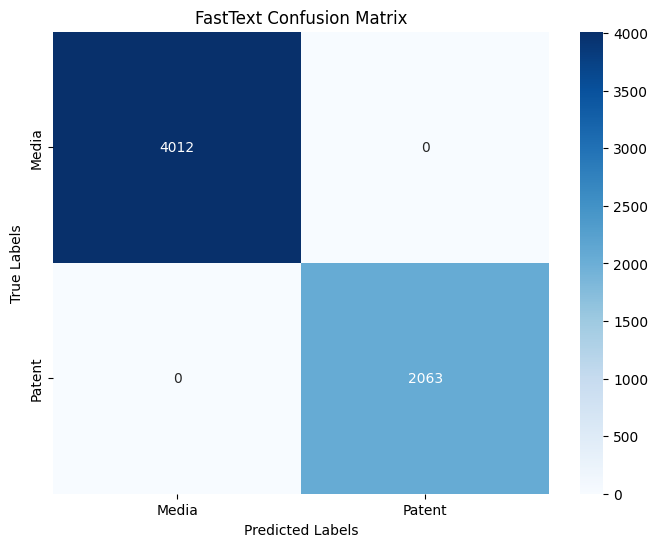

In [399]:
# Prepare validation data
X_val = np.array([get_sentence_vector(text, media_fasttext) for text in media_val['processed_text']] + 
                  [get_sentence_vector(text, patent_fasttext) for text in patent_val['processed_text']])
y_val = np.concatenate([np.zeros(len(media_val)), np.ones(len(patent_val))])

# Predict and evaluate
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Media', 'Patent'])

print(f"Classification Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Media', 'Patent'], yticklabels=['Media', 'Patent'])   
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('FastText Confusion Matrix')
plt.show()


The evaluation is very similar to the Word2Vec model, with the same parameters and evaluation metrics. The word similarity is mostly around the "solar" topic, while the dissimilar are more diverse with words such as **intentional** or **battery**.

The classification task achieves a perfect accuracy of 1.0 again, which could indicate overfitting over the training data.

## Sentence Embedding

For choosing the best model for our use case, we will compare the characteristics of **Averaging Word Vectors**, **Doc2Vec**, and **BERT Embeddings**.

| **Feature**               | **Averaging Word Vectors**                                   | **Doc2Vec**                                         | **BERT Embeddings**                                   |
|---------------------------|-------------------------------------------------------------|----------------------------------------------------|-----------------------------------------------------|
| **How It Works**          | Averages word embeddings (e.g., Word2Vec, GloVe) for all words in a sentence. | Learns embeddings for entire sentences or documents, considering context. | Uses transformer-based models to generate contextual sentence embeddings. |
| **Advantages**            | Simple, fast, and computationally efficient.                | Captures sentence-level semantics; fixed-length output. | Captures context, nuances, and sentence meaning well. |
| **Limitations**           | Loses word order and context; less effective for meaning.    | Requires large corpus; may not generalize to unseen data. | Computationally expensive and slower.                |

Based on the characteristics, we will use **BERT Embeddings** for our sentence embedding model due to its ability to capture context, nuances, and sentence meaning effectively.

In [ ]:
# Function to generate embeddings using BERT with hyperparameters
def generate_bert_embeddings(data, model_name, vector_size=768, context_window=128, learning_rate=2e-5, batch_size=16, epochs=3, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Check if CUDA is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()
    model.to(device)  # Move the model to the GPU
    
    # Adjust model configuration based on vector size
    model.config.hidden_size = vector_size
    
    # Generate embeddings for the processed text
    embeddings = []
    for text in tqdm(data['processed_text'].values, desc="Generating BERT embeddings"):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=context_window).to(device)  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract the embeddings from the second-to-last layer
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())  # Move output back to CPU
    
    # Save the model and embeddings in Google Drive
    model_path = os.path.join(save_dir, model_name + '_model.pt')
    embeddings_path = os.path.join(save_dir, model_name + '_embeddings.npy')
    
    torch.save(model.state_dict(), model_path)  # Save model weights
    np.save(embeddings_path, embeddings)  # Save embeddings as a NumPy array
    
    print(f"BERT model saved as {model_path}")
    print(f"Embeddings saved as {embeddings_path}")
    return np.array(embeddings)

# Generate embeddings for media and patent data with optimized hyperparameters
media_bert_embeddings = generate_bert_embeddings(media_train, 'media_bert', vector_size=768, context_window=512, learning_rate=5e-5, batch_size=16, epochs=3, seed=42)
patent_bert_embeddings = generate_bert_embeddings(patent_train, 'patent_bert', vector_size=768, context_window=512, learning_rate=5e-5, batch_size=16, epochs=3, seed=42)


In [ ]:
# load embeddings
media_bert_embeddings = np.load('/content/drive/MyDrive/CLT/models/media_bert_embeddings.npy')
patent_bert_embeddings = np.load('/content/drive/MyDrive/CLT/models/patent_bert_embeddings.npy')

In [404]:
# load embeddings from the folder /models/ locally
media_bert_embeddings = np.load('models/backup/media_bert_embeddings.npy')
patent_bert_embeddings = np.load('models/backup/patent_bert_embeddings.npy')

#### Sentence Similarity Task

In [ ]:
# Sentence similarity task
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two sets of sentence embeddings
def calculate_sentence_similarity(embeddings1, embeddings2):
	similarities = cosine_similarity(embeddings1, embeddings2)
	return similarities

# Calculate cosine similarity between media and patent sentence embeddings
sentence_similarities = calculate_sentence_similarity(media_bert_embeddings, patent_bert_embeddings)


#### Unique Insights and Innovation Gaps

In [432]:
# Get the indices of the top 10 most similar pairs
sorted_indices = np.dstack(np.unravel_index(np.argsort(sentence_similarities.ravel())[::-1], sentence_similarities.shape))[0]
top_pairs_indices = sorted_indices[:10]

# Display the top 10 most similar pairs
top_pairs = [(media_train['processed_text'].iloc[i], patent_train['processed_text'].iloc[j], sentence_similarities[i, j]) for i, j in top_pairs_indices]
top_pairs_df = pd.DataFrame(top_pairs, columns=['Media Text', 'Patent Text', 'Similarity'])
top_pairs_df


,Media Text,Patent Text,Similarity
0,lithium ion battery ubiquitous whether consume...,the utility model provide heat insulation coat...,0.952462
1,lithium ion battery ubiquitous whether consume...,the utility model provide guide type sky reed ...,0.949433
2,lithium ion battery ubiquitous whether consume...,system method desalination water disclose a sy...,0.947431
3,PRU ideal turn key solution utility ground mou...,the utility model disclose wide narrow frame l...,0.947363
4,SolarPower Europe develop agrisolar digital ma...,the embodiment invention provide lie type heat...,0.946467
5,lithium ion battery ubiquitous whether consume...,the utility model relate technical field dust ...,0.945756
6,PRU ideal turn key solution utility ground mou...,the invention disclose flow push device drive ...,0.945746
7,PRU ideal turn key solution utility ground mou...,the utility model provide guide type sky reed ...,0.945515
8,lithium ion battery ubiquitous whether consume...,the utility model provide fuel cell hydrogen e...,0.944908
9,lithium ion battery ubiquitous whether consume...,the invention provide novel photovoltaic panel...,0.944172


##### Unique Insights: Top 10 Similar Sentence Pairs:

The sentence similarity task shows strong semantic alignment between the media and patent datasets, with similarity scores ranging from 0.944 to 0.952. Key themes include energy storage, renewable energy, and technical innovations like lithium-ion batteries and solar power. Media texts provide broader context, while patents focus on technical details. This alignment suggests media effectively communicates key innovations, bridging the gap between technical advancements and public awareness. 

Notice that the first 3 sentences are from the media dataset are identical, which could indicate redundancy in the dataset, either due to duplicate entries or similar content (same media from different sources), or that the similarity matrix points to the same sentence in the media dataset as the most similar to different sentences in the patent dataset.



In [436]:
# Show the top 10 most dissimilar pairs with unique Patent Texts
selected_patent_indices = set()
bottom_pairs = []

for i, j in sorted_indices[::-1]:  # Iterate over sorted indices in ascending order
    if j not in selected_patent_indices:  # Ensure unique Patent Texts
        bottom_pairs.append((media_train['processed_text'].iloc[i], patent_train['processed_text'].iloc[j], sentence_similarities[i, j]))
        selected_patent_indices.add(j)
    if len(bottom_pairs) == 10:  # Stop after 10 pairs
        break

# Create DataFrame for bottom pairs
bottom_pairs_df = pd.DataFrame(bottom_pairs, columns=['Media Text', 'Patent Text', 'Similarity'])
bottom_pairs_df

,Media Text,Patent Text,Similarity
0,create free IEA account download report subcri...,the utility model belong technical field solar...,0.107702
1,our pv magazine newshound walk floor one last ...,system method remove charge buildup leakage so...,0.353039
2,abstract currently accept German Geothermal Co...,the invention belong technical field photovolt...,0.377915
3,by click allow all agree storing cookie device...,the utility model belong technical field heati...,0.396104
4,our pv magazine newshound walk floor one last ...,the utility model disclose foldable solar comp...,0.404390
5,by click allow all agree storing cookie device...,the invention disclose solar photo thermal pho...,0.406614
6,join we webinar October emission management so...,the invention provide hydrogen energy mope con...,0.422297
7,a business base namibian mine sign year power ...,the embodiment disclosure relate intelligent t...,0.423801
8,create free IEA account download report subcri...,system method provide solar generate power dis...,0.425509
9,create free IEA account download report subcri...,the invention disclose power increase wind tur...,0.440385


##### Innovation Gaps: Top 10 Dissimilar Sentence Pairs:

The top 10 dissimilar sentence pairs, with similarity scores ranging from 0.107 to 0.440, reveal significant gaps between media and patent texts. Media texts focus on general narratives like industry updates and webinars, while patent texts emphasize technical innovations such as "foldable solar components" and "solar photo thermal systems." This highlights a lack of alignment in focus, with media failing to adequately cover technical advancements and their practical applications. Bridging this gap through better communication and highlighting underexplored topics like hydrogen energy systems or solar energy could foster greater public awareness and innovation adoption.

#### Clustering

c:\Users\advar\Desktop\Titulos académicos\MASTER DATA SCIENCE\OneDrive - Hochschule Luzern\Subjects\NLP\W.MSCIDS_CTA03.F25\Project\NLP\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


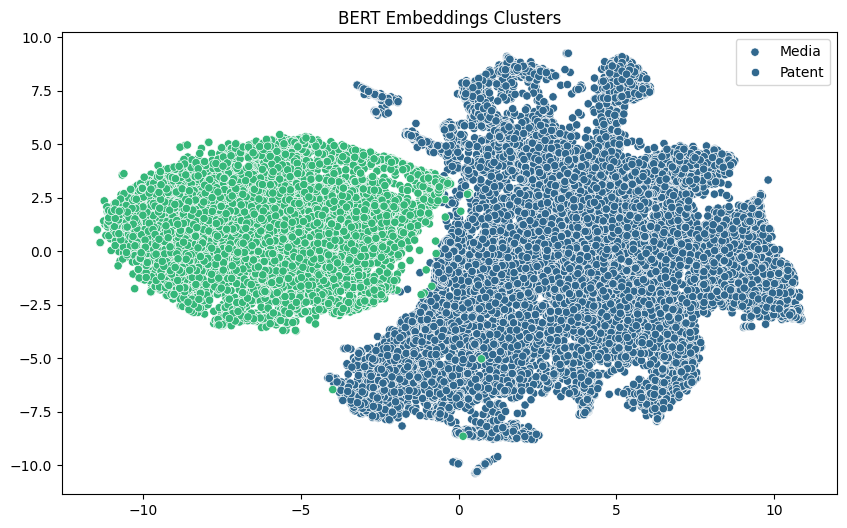

In [438]:
# Function to visualize clusters using PCA and t-SNE
def visualize_clusters(embeddings, labels, title):
	# Reduce dimensions using PCA
	pca = PCA(n_components=50)
	pca_embeddings = pca.fit_transform(embeddings)
	
	# Further reduce dimensions using t-SNE
	tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
	tsne_embeddings = tsne.fit_transform(pca_embeddings)
	
	# Ensure labels match the number of embeddings
	if len(tsne_embeddings) != len(labels):
		raise ValueError("The number of embeddings and labels must match.")
	
	# Plot the clusters
	plt.figure(figsize=(10, 6))
	sns.scatterplot(
		x=tsne_embeddings[:, 0], 
		y=tsne_embeddings[:, 1], 
		hue=labels[:len(tsne_embeddings)], 
		palette='viridis', 
		legend='full'
	).legend(labels=['Media', 'Patent'])
	plt.title(title)
	plt.show()

# Prepare labels for visualization
labels = np.concatenate([np.zeros(len(media_bert_embeddings)), np.ones(len(patent_bert_embeddings))])

# Visualize clusters for BERT embeddings
visualize_clusters(np.concatenate([media_bert_embeddings, patent_bert_embeddings]), labels, title="BERT Embeddings Clusters")


The visualization shows clear separation between the **Media** (green) and **Patent** (blue) clusters, indicating that BERT embeddings effectively capture semantic differences between the datasets.

#### Key Observations:
1. **Separation**: The clusters are well-separated, demonstrating strong semantic distinction between the datasets.
2. **Density**: The Media cluster is more compact, suggesting thematic consistency, while the Patent cluster is more dispersed, reflecting greater topic diversity.
3. **Outliers**: Minimal overlap and a few outliers near the boundary may represent mixed or ambiguous content.

#### Conclusion:
The embeddings effectively distinguish the datasets, making them suitable for classification and thematic analysis. Further exploration of outliers and sub-clusters could provide additional insights.

#### Classification Task with BERT Embeddings

Classification Accuracy: 0.9998353909465021
Classification Report:
              precision    recall  f1-score   support

       Media       1.00      1.00      1.00      4012
      Patent       1.00      1.00      1.00      2063

    accuracy                           1.00      6075
   macro avg       1.00      1.00      1.00      6075
weighted avg       1.00      1.00      1.00      6075



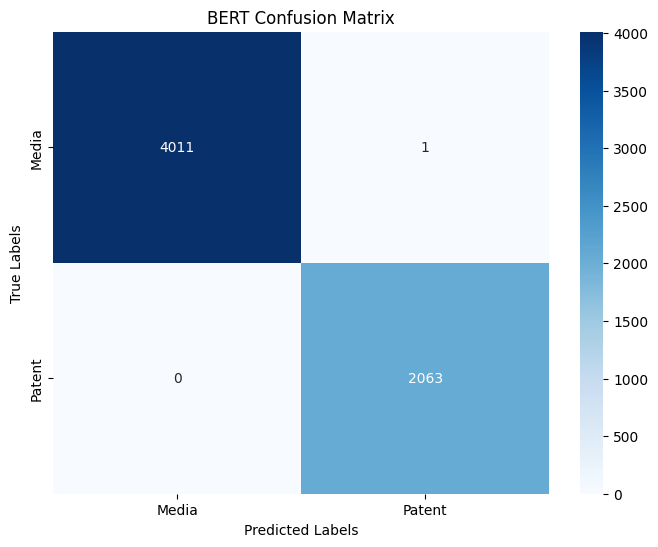

In [442]:
# Classification using BERT embeddings on the validation set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare training data
X_train = np.concatenate([media_bert_embeddings, patent_bert_embeddings])
y_train = np.concatenate([np.zeros(len(media_bert_embeddings)), np.ones(len(patent_bert_embeddings))])

# Train Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Prepare validation data
media_val_embeddings = np.array([media_bert_embeddings[i] for i in range(len(media_val))])
patent_val_embeddings = np.array([patent_bert_embeddings[i] for i in range(len(patent_val))])
X_val = np.concatenate([media_val_embeddings, patent_val_embeddings])
y_val = np.concatenate([np.zeros(len(media_val)), np.ones(len(patent_val))])

# Predict and evaluate
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Media', 'Patent'])

print(f"Classification Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Media', 'Patent'], yticklabels=['Media', 'Patent'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT Confusion Matrix')
plt.show()

### Insight / Conclusion

The classification using **BERT embeddings** achieves near-perfect performance with an **accuracy of 0.9998**. Both **Media** and **Patent** classes have precision, recall, and F1-scores of **1.00**, as shown in the classification report. The confusion matrix confirms almost no misclassifications, demonstrating that the embeddings effectively capture semantic differences between the datasets.

#### Implications:
The results highlight the strength of BERT embeddings for text classification. However, the extremely high accuracy may indicate potential overfitting, and further testing on unseen or diverse datasets is recommended to ensure generalization.